# Imports 

In [22]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import string
import re
import argparse
import json
from sklearn import neighbors, datasets
import os
import sys
import random
import shutil
import time
import torch.nn.parallel
from tqdm import tqdm
import torch.optim
import torch.utils.data
import torchvision.datasets as datasets
from torch.autograd import Variable
from PIL import Image
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import multivariate_normal
import  scipy.stats as st
from matplotlib import cm
from __future__ import print_function
from spacy.lang.en import English
from sklearn.cluster import KMeans
import pickle
import matplotlib
from sklearn.metrics.pairwise import rbf_kernel
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import scipy.stats as st
#import lime
#import lime.lime_tabular


In [35]:
class HumanLearner:
    """ Model of Human Learner.
    Learner has a list of training points each with a radius and label.
    Learner follows the radius nearest neighbor assumption.
    """
    def __init__(self, kernel):
        '''
        Args:
            kernel: function that takes two inputs and returns a similarity
        '''
        self.teaching_set = []
        self.kernel = kernel

    def predict(self, xs, prior_rejector_preds, to_print = False):
        '''
        Args:
            xs: x points 
            prior_rejector_preds: predictions of prior rejector
        Return:
            preds: posterior human learner rejector predictions
        '''
        preds = []
        idx = 0
        used_posterior = 0 
        for x in xs:
            ball_at_x = []
            similarities = self.kernel(x.reshape(1,-1), np.asarray([self.teaching_set[kk][0] for kk in range(len(self.teaching_set))]))[0]
            for i in range(len(self.teaching_set)):
                similarity = similarities[i]
                if similarity >=  self.teaching_set[i][2]:
                    ball_at_x.append(self.teaching_set[i])
            if len(ball_at_x) == 0: 
                preds.append(prior_rejector_preds[idx])
            else:
                used_posterior += 1
                ball_similarities = self.kernel(x.reshape(1,-1), np.asarray([ball_at_x[kk][0] for kk in range(len(ball_at_x))]))[0]
                normalization = np.sum([ball_similarities[i] for i in range(len(ball_at_x))])
                score_one = np.sum([ball_similarities[i]*ball_at_x[i][1] for i in range(len(ball_at_x))])
                pred = score_one / normalization
                if pred >= 0.5:
                    preds.append(1)
                else:
                    preds.append(0)
            idx += 1
        
        return preds

    def add_to_teaching(self, teaching_example):
        '''
        adds teaching_example to training set
        args:
            teaching_example: (x, label, gamma)
        '''
        self.teaching_set.append(teaching_example)

    def remove_last_teaching_item(self):
        """ removes last placed teaching example from training set"""
        self.teaching_set = self.teaching_set[:-1]


In [24]:
def compute_predictions_humanai(hum_preds, hum_rejector, ai_preds, data_x):
    '''
    hum_preds: array of human predictions
    ai_preds: array of AI predictions
    hum_rejector: HumanLearner
    data_x: array of inputs

    Returns array of final predictions and deferalls
    '''
    predictions = []
    with torch.no_grad():
        reject_decisions = hum_rejector(data_x)
        for i in range(len(data_x)):
            if reject_decisions[i] == 1:
                # defer
                predictions.append(ai_preds[i])
            else:
                predictions.append(hum_preds[i])
    return predictions, reject_decisions

def get_metrics(preds, truths, metric_y):
    # to be implemented for each method, higher better
    '''
    preds: array of predictions
    truths:  target array
    '''
    acc = metric_y(truths, preds) #metrics.accuracy_score(truths, preds)
    metrics_computed = { "score": acc}
    return metrics_computed

def compute_metrics(human_preds, ai_preds, reject_decisions, truths, metric_y, to_print = False):
    coverage = 1 - np.sum(reject_decisions)/len(reject_decisions)
    humanai_preds = []
    human_preds_sys = []
    truths_human = []
    ai_preds_sys = []
    truths_ai = []
    for i in range(len(reject_decisions)):
        if reject_decisions[i] == 1:
            humanai_preds.append(ai_preds[i])
            ai_preds_sys.append(ai_preds[i])
            truths_ai.append(truths[i])
        else:
            humanai_preds.append(human_preds[i])
            human_preds_sys.append(human_preds[i])
            truths_human.append(truths[i])
    humanai_metrics = get_metrics(humanai_preds, truths, metric_y)

    human_metrics = get_metrics(human_preds_sys, truths_human, metric_y)

    ai_metrics = get_metrics(ai_preds_sys, truths_ai, metric_y)

    if to_print:
        print(f'Coverage is {coverage*100:.2f}')
        print(f' metrics of system are: {humanai_metrics}')
        print(f' metrics of human are: {human_metrics}')
        print(f' metrics of AI are: {ai_metrics}')
    return coverage, humanai_metrics, human_metrics, ai_metrics

In [52]:
class TeacherExplainer():
    """ Returns top examples that best teach a learner when to defer to a classifier.
    Given a tabular dataset with classifier predictions, human predictions and a similarity metric,
    the method returns the top k images that best describe when to defer to the AI.    
     """

    def __init__(self,
                data_x,
                data_y,
                hum_preds,
                ai_preds,
                prior_rejector_preds,
                sim_kernel,
                metric_y,
                alpha = 1,
                teaching_points = 10):
            """Init function.
            Args:
                data_x: 2d numpy array of the features
                data_y: 1d numpy array of labels
                hum_preds:  1d array of the human predictions 
                ai_preds:  1d array of the AI predictions 
                prior_rejector_preds: 1d binary array of the prior rejector preds 
                sim_kernel: function that takes as input two inputs and returns a positive number
                metric_y: metric function (positive, the higher the better) between predictions and ground truths 
                alpha: parameter of selection algorithm, set to 1 for now
            """
            self.data_x = data_x
            self.data_y = data_y
            self.hum_preds = hum_preds
            self.data_y = data_y
            self.ai_preds = ai_preds
            self.kernel = sim_kernel
            self.prior_rejector_preds = prior_rejector_preds
            self.metric_y = metric_y
            self.alpha = alpha
            self.teaching_points = teaching_points

    def get_optimal_deferral(self):
        '''
        gets optimal deferral decisions computed emperically
        Return:
            opt_defer: optimal deferral decisions 

        '''
        opt_defer_teaching = []
        for ex in range(len(self.hum_preds)):
            score_hum = self.metric_y([self.data_y[ex]], [self.hum_preds[ex]])
            score_ai = self.metric_y([self.data_y[ex]], [self.ai_preds[ex]])
            if score_hum >= score_ai:
                opt_defer_teaching.append(0)
            else:
                opt_defer_teaching.append(1)
        self.opt_defer = np.array(opt_defer_teaching)
        return np.array(opt_defer_teaching)


    def get_optimal_consistent_gammas(self):
        '''
        get optimal consistent gammas
        Return:
            optimal_consistent_gammas: array of optimal consistent gamma values
        '''
        optimal_consistent_gammas = []
        with tqdm(total=len(self.data_x)) as pbar:
            similarities_embeds_all = self.kernel( np.asarray(self.data_x), np.asarray(self.data_x)) # kernel matrix
            self.similarities_embeds_all = similarities_embeds_all # save kernel matrix
            for i in range(len(self.data_x)):
                # get all similarities
                similarities_embeds = similarities_embeds_all[i]
                opt_defer_ex = self.opt_defer[i]
                opt_gamma = 1
                sorted_sim = sorted([(similarities_embeds[k], self.opt_defer[k]) for k in range(len(self.data_x))], key=lambda tup: tup[0])
                indicess = list(range(1, len(self.opt_defer)))
                indicess.reverse()
                for k in indicess:
                    if sorted_sim[k][1] == opt_defer_ex and sorted_sim[k- 1][1] != opt_defer_ex:
                        opt_gamma = sorted_sim[k][0]
                        break
                optimal_consistent_gammas.append(opt_gamma)
                pbar.update(1)
        self.optimal_consistent_gammas = np.array(optimal_consistent_gammas)
        return np.array(optimal_consistent_gammas)

    def get_improvement_defer_consistent(self, current_defer_preds):
        '''
        Gets how much would score improve in terms of metric_y if you add each point to the teaching set 
        Assumption: assumes metric_y over all data is decomposed as the average of metric_y for each data point e.g. 0-1 loss
        Relaxation: instead of simulating human learner, we assume if point added to the human's set, human will follow the points optimal decision
        Note: for the consistent gamma strategy, the relaxation does not affect the result
        Args:
            current_defer_preds: current predictions of human learner on teaching set
        Return:
            error_improvements: improvement of adding point i for each i in data to the human training set
        '''
        error_improvements = []
        error_at_i = 0
        for i in range(len(self.data_x)):
            error_at_i = 0
            similarities_embeds = self.similarities_embeds_all[i]
            # get the ball for x
            # in this ball how many does the current defer not match the optimal
            for j in range(len(similarities_embeds)):
                if similarities_embeds[j] >= self.optimal_consistent_gammas[i]:
                    score_hum = self.metric_y([self.data_y[j]], [self.hum_preds[j]])
                    score_ai = self.metric_y([self.data_y[j]], [self.ai_preds[j]])
                    if self.opt_defer[i] == 1:
                        if current_defer_preds[j] == 0:
                            error_at_i += score_ai - score_hum
                    else:
                        if current_defer_preds[j] == 1:
                            error_at_i += score_hum - score_ai
            error_improvements.append(error_at_i)

        return error_improvements


    def teach_consistent(self, to_print = False, plotting_interval = 2):
        '''
        our greedy consistent selection algorithm, updates human learner
        returns:
            errors: training errors after adding each teaching point
            indices_used: indices used for teaching 
        '''
        errors = []
        data_sizes  = []
        indices_used = []
        points_chosen = []
        plotting_interval = 2 # plotting interval
        for itt in range(self.teaching_points):
            print(f'New size {itt}')
            best_index = -1
            # predict with current human learner
            if itt == 0:
                preds_teach = self.prior_rejector_preds
            else:
                preds_teach = self.human_learner.predict(self.data_x, self.prior_rejector_preds)
            # get improvements for each point if added
            error_improvements = self.get_improvement_defer_consistent(preds_teach)
            # pick best point and add it
            best_index = np.argmax(error_improvements)
            indices_used.append(best_index) # add found element to set used
            ex_embed = self.data_x[best_index]
            ex_label = self.opt_defer[best_index]
            gamma = self.optimal_consistent_gammas[best_index]
            if to_print:
                print(f'got improvements with max {max(error_improvements)}')
            self.human_learner.add_to_teaching([ex_embed, ex_label, gamma])

            # evaluate on teaching points
            if to_print and itt % plotting_interval == 0:
                print("####### train eval " + str(itt)+ " ###########")
                preds_teach = self.human_learner.predict(self.data_x, self.prior_rejector_preds)
                _, metricss, __, ___ = compute_metrics(self.hum_preds, self.ai_preds, preds_teach, self.data_y, self.metric_y, to_print)
                errors.append(metricss['score'])   
                print("##############################")
        
        return errors, indices_used


    def get_teaching_examples(self, to_print = False, plot_interval = 2):
        """ obtains teaching points. Currently only implemented for consistent strategy
        Args:
            to_print: display details of teaching process
            plot_interval: how often to plot results
        Return:
            teaching_x: 2d numpy array of teaching points features
            teaching_indices: indices of the teaching points in self.data_x
            teaching_gammas: 1d numpy of gamma values used
            teaching_labels: 1d array of deferral labels where 1 signifies defer to AI and 0 signifies don't defer to AI
        
        """
        assert self.alpha == 1, "Only consistent strategy implemented with alpha=1"

        # run algorithm to get examples
        # get optimal deferrall points
        print("getting gammas and optimal deferral decisions on teaching set")
        self.get_optimal_deferral()
        # get consistentg
        self.get_optimal_consistent_gammas()
        self.human_learner = HumanLearner(self.kernel)
        print("starting the teaching process ...")
        errors, indices_used = self.teach_consistent(to_print, plot_interval)
        teaching_x = self.data_x[indices_used]
        teaching_indices = indices_used
        teaching_gammas = self.optimal_consistent_gammas[indices_used]
        teaching_labels = self.opt_defer[indices_used]

        return teaching_x, teaching_gammas, teaching_labels, teaching_indices

# test on synthetic data

In [ ]:

def sample(mu, var, nb_samples=500):
    """
    :param mu: torch.Tensor (features)
    :param var: torch.Tensor (features) (note: zero covariance)
    :return: torch.Tensor (nb_samples, features)
    """
    out = []
    for i in range(nb_samples):
        out += [
            torch.normal(mu, var.sqrt())
        ]
    return torch.stack(out, dim=0)

    

In [ ]:

class Linear_net_sig(nn.Module):
    def __init__(self, input_dim):
        super(Linear_net_sig, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

def run_classifier_sig(net, data_x, data_y, n_epochs = 10000):
    '''
    training code using GD
    '''
    BCE = torch.nn.BCELoss(size_average=True)
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000*10000)
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        # get the inputs; data is a list of [inputs, labels]
        inputs = data_x
        labels = data_y
        order = np.array(range(len(data_x)))
        np.random.shuffle(order)
        # in-place changing of values
        inputs[np.array(range(len(data_x)))] = inputs[order]
        labels[np.array(range(len(data_x)))] = labels[order]
        # zero the parameter gradients

        # forward + backward + optimize
        outputs = net(inputs)[:,0]

        loss = BCE(outputs, labels*1.0) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        running_loss += loss.item()
        if epoch % 10000 == 0:
            print("loss " + str(loss.item()))

    #print('Finished Training')


def test_classifier_sig(net, data_x, data_y):
    correct = 0
    total = 0
    with torch.no_grad():
        inputs =  data_x
        labels = data_y
        outputs = net(inputs)
        predicted = torch.round(outputs.data)
        total = labels.size(0)
        for i in range(total):
            correct += predicted[i].item() == labels[i].item()
        #correct = (predicted == labels).sum()
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc
def conv_to_color(arr):
    cols = []
    for a in arr:
        if a == 1:
            cols.append("blue")
        else:
            cols.append("red")
    return cols

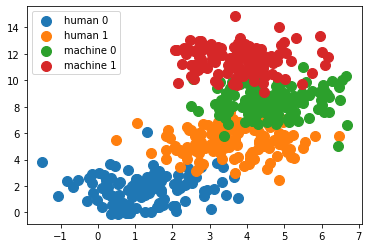

In [ ]:

d = 2
total_samples = 500
mean_scale = 12
variance = 1.0
group_proportion = 0.5#np.random.uniform()
'''
if group_proportion <= 0.02:
    group_proportion = 0.02
if group_proportion >= 0.98:
    group_proportion = 0.98
#group_proportion = 0.4
'''
cluster1_mean = torch.rand(d)*mean_scale
cluster1_var = torch.tensor(variance)#torch.rand(d)*d
cluster1 = sample(
    cluster1_mean,
    cluster1_var,
    nb_samples= math.floor(total_samples * group_proportion * 0.5 )
)
cluster1_labels = torch.ones([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)
cluster2_mean = torch.rand(d)*mean_scale
cluster2_var = torch.tensor(variance)#torch.rand(d)*d
cluster2 = sample(
    cluster2_mean,
    cluster2_var,
    nb_samples= math.floor(total_samples * group_proportion * 0.5 )
)
cluster2_labels = torch.zeros([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)
cluster3_mean = torch.rand(d)*mean_scale
cluster3_var = torch.tensor(variance)#torch.rand(d)*d
cluster3 = sample(
    cluster3_mean,
    cluster3_var,
    nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
)
cluster3_labels = torch.ones([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

cluster4_mean = torch.rand(d)*mean_scale
cluster4_var = torch.tensor(variance)#torch.rand(d)*d
cluster4 = sample(
    cluster4_mean,
    cluster4_var,
    nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
)
cluster4_labels = torch.zeros([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

# test data
cluster1_test = sample(
    cluster1_mean,
    cluster1_var,
    nb_samples= math.floor(total_samples * group_proportion * 0.5 )
)
cluster1_labels_test = torch.ones([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)

cluster2_test = sample(
    cluster2_mean,
    cluster2_var,
    nb_samples= math.floor(total_samples * group_proportion * 0.5 )
)
cluster2_labels_test = torch.zeros([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)

cluster3_test = sample(
    cluster3_mean,
    cluster3_var,
    nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
)
cluster3_labels_test = torch.ones([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

cluster4_test = sample(
    cluster4_mean,
    cluster4_var,
    nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
)
cluster4_labels_test = torch.zeros([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

fig, ax = plt.subplots(1)
x1 = cluster1.numpy()
x2 = cluster2.numpy()
x3 = cluster3.numpy()
x4 = cluster4.numpy()
epsilon = 0.8
ax.set_facecolor('white')
#ax.set(xlim=(-4, 10), ylim=(-4, 10))
#ax.vlines([-12,-6,0,6,12.3],-12,12.3)
#ax.hlines([-12,-6,0,6,12.3],-12,12.3)
#ax.plot([x1h, x2h], [y1h, y2h], color='red', marker='x',label = "human")
#ax.plot([x1m, x2m], [y1m, y2m], color='blue', marker='x',label = "machine")

scatter = mscatter(x1[:, 0], x1[:, 1],  cmap='RdBu',  ax=ax,s=100, label="human 0")
scatter = mscatter(x2[:, 0], x2[:, 1], cmap='RdBu',  ax=ax,s=100, label="human 1")
scatter = mscatter(x3[:, 0], x3[:, 1],  cmap='RdBu',  ax=ax,s=100, label="machine 0")
scatter = mscatter(x4[:, 0], x4[:, 1],  cmap='RdBu',  ax=ax,s=100, label="machine 1")
plt.legend()
plt.show()

In [ ]:
print("Obtaining AI")
net_machine = Linear_net_sig(d)
data_x = torch.cat([cluster3, cluster4])
data_y = torch.cat([cluster3_labels, cluster4_labels])
run_classifier_sig(net_machine, data_x, data_y, 50000)

print("Obtaining human")
net_human = Linear_net_sig(d)
data_x = torch.cat([cluster1, cluster2])
data_y = torch.cat([cluster1_labels, cluster2_labels])
run_classifier_sig(net_human, data_x, data_y, 50000)


Obtaining AI
loss 2.623969793319702


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.28343623876571655
loss 0.2529910206794739
loss 0.23071178793907166
loss 0.21406297385692596
Obtaining human
loss 0.6173954010009766
loss 0.12918274104595184
loss 0.10199941694736481
loss 0.09191342443227768
loss 0.08665629476308823


NameError: ignored

In [27]:
data_x = torch.cat([cluster1, cluster2, cluster3, cluster4])
data_y = torch.cat([cluster1_labels, cluster2_labels, cluster3_labels, cluster4_labels])
data_x_np = data_x.numpy()
data_y_np = data_y.numpy()
outputs = net_human(data_x)
predicted_hum = torch.round(outputs.data).numpy()[:,0]
outputs = net_machine(data_x)
predicted_mach = torch.round(outputs.data).numpy()[:,0]
# I need prior
# I need alpha
alpha = 0

In [28]:
prior_rejector = []
epsilon = 0.9
with torch.no_grad():
    inputs =  data_x
    labels = data_y
    outputs = net_human(inputs)
    predicted = torch.round(outputs.data)
    for i in range(len(inputs)):
        r_score = max(1 - outputs.data[i].item(), outputs.data[i].item())
        r = 0
        if r_score <  epsilon:
            r = 1
        else:
            r =  0
        prior_rejector.append(r)

In [29]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import accuracy_score
kernel = rbf_kernel
metric_y = accuracy_score


In [40]:
accuracy_score([1],[0])

0.0

In [46]:
teacher = TeacherExplainer(data_x_np, data_y_np, predicted_hum, predicted_mach, prior_rejector, kernel, metric_y, 1, 50)

In [47]:
print(teacher.get_teaching_examples())

  0%|          | 0/500 [00:00<?, ?it/s]


NameError: ignored

In [ ]:
class TeacherExplainer():
    """ Returns top examples that best teach a learner when to defer to a classifier.
    Given a tabular dataset with classifier predictions, human predictions and a similarity metric,
    the method returns the top k images that best describe when to defer to the AI.    
     """

    def __init__(self,
                data_x,
                data_y,
                hum_preds,
                ai_preds,
                prior_rejector_preds,
                sim_kernel,
                metric_y,
                alpha = 1,
                teaching_points = 10):

GOAL

general:

given dataloader and costs, retreive set of points and their indices and gammas, and distance metric

input:
- 
- 
- 

test case
- images with cifar 

- adult dataset fake expert

- 

